# Alanine Multistate
## Example Simulation

This uses the state definition from [1]. 6 states named A,B,C,D,E and F

[1] W.-N. Du, K. A. Marino, and P. G. Bolhuis, “Multiple state transition interface sampling of alanine dipeptide in explicit solvent,” J. Chem. Phys., vol. 135, no. 14, p. 145102, 2011.

Import Modules

In [1]:
import numpy as np
import mdtraj as md
import pandas as pd
import time
import sys, os
import math

import openpathsampling as paths
import simtk.unit as u

from openpathsampling.visualize import PathTreeBuilder
from IPython.display import SVG

In [2]:
# Imports for plotting
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib.legend_handler import HandlerLine2D

Radians to Degree conversion

In [3]:
degrees = 180/3.14159 # psi reports in radians; I think in degrees

Create an AlanineOpenMMSimulator for demonstration purposes

### Set simulation options and create a simulator object

Set the regular simulation parameters

In [4]:
options = {
            'temperature' : 300.0 * u.kelvin,
            'collision_rate' : 1.0 / u.picoseconds,
            'timestep' : 2.0 * u.femtoseconds,
            'nsteps_per_frame' : 5,
            'n_frames_max' : 5000,
            'start_time' : time.time(),
            'fn_initial_pdb' : "../data/Alanine_solvated.pdb",
            'platform' : 'fastest',
            'solute_indices' : range(22),
            'forcefield_solute' : 'amber96.xml',
            'forcefield_solvent' : 'tip3p.xml'
           }

Set a high temperature simulation for exploration.

In [5]:
options_high = {
            'temperature' : 600.0 * u.kelvin,
            'collision_rate' : 1.0 / u.picoseconds,
            'timestep' : 2.0 * u.femtoseconds,
            'nsteps_per_frame' : 5,
            'n_frames_max' : 5000,
            'start_time' : time.time(),
            'fn_initial_pdb' : "../data/Alanine_solvated.pdb",
            'platform' : 'fastest',
            'solute_indices' : range(22),
            'forcefield_solute' : 'amber96.xml',
            'forcefield_solvent' : 'tip3p.xml'
           }

In [6]:
template = paths.tools.snapshot_from_pdb("../data/Alanine_solvated.pdb")
engine = paths.OpenMMEngine(
                template=template,
                options=options
                )
engine.name = 'default'
engine_high = paths.OpenMMEngine(
                template=template,
                options=options_high
                )
engine_high.name = 'high'

In [7]:
paths.SampleGeneratingMover.engine = engine

In [8]:
storage = paths.storage.Storage("ala.nc", mode='w', template=template)

In [9]:
storage.save(engine)
storage.save(engine_high)

True

And save the storage in a separate variable for convenience

In [10]:
platform = engine.simulation.context.getPlatform()

In [11]:
print platform.getName()

CUDA


Equilibrate

In [12]:
engine.current_snapshot = engine.template
engine.equilibrate(5)
engine_high.current_snapshot = engine.template
engine_high.equilibrate(5)

Save equilibrated snapshot with index 0

In [13]:
storage.save(engine.current_snapshot);

### Order Parameters

this generates an order parameter (callable) object named psi (so if we call `psi(trajectory)` we get a list of the values of psi for each frame in the trajectory). This particular order parameter uses mdtraj's compute_dihedrals function, with the atoms in psi_atoms

In [14]:
psi_atoms = [6,8,14,16]
psi = paths.CV_MD_Function("psi", md.compute_dihedrals,
                  indices=[psi_atoms])

phi_atoms = [4,6,8,14]
phi = paths.CV_MD_Function("phi", md.compute_dihedrals,
                  indices=[phi_atoms])

storage.save([psi, phi]);

### Volumes

This creates two states using a one-dimensional order parameter (called _Lambda_ in TIS terminology). A snapshot is in the State as long as the order parameter is with specific bounds. 

Define state as in [1]

In [15]:
state_letter = {
    'A' : 'A',
    'B' : 'B',
    'C' : 'C',
    'D' : 'D',
    'E' : 'E',
    'F' : 'F',
    'alpha' : u'α',
    'beta' : u'β'
}

In [16]:
state_centers = {
    'A' : [-150, 150], 
    'B' : [-70, 135], 
    'C' : [-150, -65], 
    'D' : [-70, -50], 
    'E' : [50, -100], 
    'F' : [40, 65]
}

In [17]:
interface_levels = {
    'A' : [10, 20, 45, 65, 80],
    'B' : [10, 20, 45, 65, 75],
    'C' : [10, 20, 45, 60],
    'D' : [10, 20, 45, 60],
    'E' : [10, 20, 45, 65, 80],
    'F' : [10, 20, 45, 65, 80],
    'alpha' : [10, 20, 45, 55, 65, 75],
    'beta' : [10, 20, 40, 45, 50, 60],    
}

In [18]:
def circle_degree(snapshot, center, phi, psi):
    psi_deg = psi(snapshot) * degrees
    phi_deg = phi(snapshot) * degrees
    return math.sqrt(
            ( min( phi_deg - center[0], 360 - phi_deg + center[0])**2 + 
              min( psi_deg - center[1], 360 - psi_deg + center[1])**2)
             )

op_state = dict()
for state in state_centers:
    op = paths.CV_Function(
        name = 'op' + state,
        fcn=circle_degree,
        center=state_centers[state],
        psi=psi,
        phi=phi
    )
    op_state[state] = op

Create `Volume` objects for all states

In [19]:
vol_state = dict()
for state in op_state:
    vol_state[state] = paths.CVRangeVolume(op_state[state], lambda_max=10.0)
    
vol_state['alpha'] = vol_state['A'] & vol_state['B']
vol_state['beta'] = vol_state['C'] & vol_state['D']

Create Interfaces

In [20]:
interface_list = {}
for state in interface_levels:
    levels = interface_levels[state]
    interface_list[state] = [None] * len(levels)
    for idx, level in enumerate(levels):
        if state == 'alpha':
            interface_list[state][idx] = \
                paths.CVRangeVolume(op_state['A'], lambda_max=level) | \
                paths.CVRangeVolume(op_state['B'], lambda_max=level)
        elif state == 'beta':
            interface_list[state][idx] = \
                paths.CVRangeVolume(op_state['C'], lambda_max=level) | \
                paths.CVRangeVolume(op_state['D'], lambda_max=level)
        else:
            interface_list[state][idx] = \
                paths.CVRangeVolume(op_state[state], lambda_max=level)

In [21]:
def get_state(snapshot):
    for name in ['A', 'B', 'C', 'D', 'E', 'F']:
        if interface_list[name][-1](snapshot):
            return name

    return 'X'

def get_core(snapshot):
    for name in ['A', 'B', 'C', 'D', 'E', 'F']:
        if interface_list[name][0](snapshot):
            return name

    return 'X'

def get_interface(snapshot):
    for name in ['A', 'B', 'C', 'D', 'E', 'F']:
        for idx, interface in enumerate(interface_list[name]):
            if interface(snapshot):
                return name, idx

    return 'X', 0

In [22]:
for name in ['A', 'B', 'C', 'D', 'E', 'F']:
    op = op_state[name]
    print name, op(storage.template),
    for idx, interface in enumerate(interface_list[name]):
        if interface(storage.template):
            print '+',
            current_state = name
        else:
            print '-',

    print    
    
print 'The initial configuration is in state', current_state

A 174.812980425 - - - - -
B 145.635273243 - - - - -
C 88.6873816287 - - - -
D 41.0137454927 - - + +
E 158.128013805 - - - - -
F 141.833432787 - - - - -
The initial configuration is in state D


In [23]:
paths.SampleGeneratingMover.engine = engine_high

First we need to get at least one conformation in each state. Since this problem is realated to the problem of finding initial trajectories we do both at the same time.

In [24]:
stA, stB, stC, stD, stE, stF, stAlpha, stBeta = [
    interface_list[state][0] for state in ['A','B','C','D','E','F','alpha','beta']
]

In [25]:
stAll = stA | stB | stC | stD | stE | stF

In [26]:
reach_core = paths.SequentialEnsemble([
        paths.OptionalEnsemble(paths.AllOutXEnsemble(stAlpha | stBeta)),
        paths.LengthEnsemble(1) & paths.AllOutXEnsemble(stAlpha | stBeta)
    ])

In [27]:
init_traj = engine_high.generate(storage.template, [reach_core.can_append])

In [28]:
current_snapshot = init_traj[-1]

Minimize until we reach one core

In [29]:
go_to_state = paths.SequentialEnsemble([
        paths.OptionalEnsemble(paths.AllInXEnsemble(stAll)),
        paths.AllOutXEnsemble(stAll),
        paths.LengthEnsemble(1) & paths.AllInXEnsemble(stAll)
    ])

In [30]:
alpha_to_beta = paths.SequentialEnsemble([
        paths.SingleFrameEnsemble(paths.AllInXEnsemble(stAlpha)),
        paths.AllOutXEnsemble(stAlpha | stBeta),
        paths.SingleFrameEnsemble(paths.AllInXEnsemble(stBeta))
    ])
beta_to_alpha = paths.SequentialEnsemble([
        paths.SingleFrameEnsemble(paths.AllInXEnsemble(stBeta)),
        paths.AllOutXEnsemble(stAlpha | stBeta),
        paths.SingleFrameEnsemble(paths.AllInXEnsemble(stAlpha))
    ])

In [31]:
alpha_beta_flip = alpha_to_beta | beta_to_alpha

In [32]:
def cvlines(data, *cvs):
    all_points = [cv(data) for cv in cvs]
    ret = []
    first = 0
    for d in range(1,len(data)):
        flip = False
        for c in range(len(cvs)):
            if periodicflip(all_points[c][d], all_points[c][d-1], math.pi):
                flip = True
                                
        if flip:
            ret.append([all_points[c][first:d] for c in range(len(cvs))])
            first = d

    ret.append([all_points[c][first:d+1] for c in range(len(cvs))])    
            
    return ret
            
    
def periodicflip(val1, val2, period):
    return (period**2 - (val1 - val2)**2) < (val1 - val2)**2

In [33]:
current_snapshot = init_traj[-1]

In [34]:
while True:
    traj1 = engine_high.generate(current_snapshot, [alpha_beta_flip.can_append])
    current_snapshot = traj1[-1]

    subtraj = alpha_beta_flip.split(traj1)
    
#    print len(traj1)
    
    if len(subtraj) > 0:
        
        traj2 = subtraj[0]
        
        print 'The initial configuration is in state', current_state
        print '[' + str(len(traj2)) + ']' + '>' + ''.join(['A' if stAlpha(s) else 'B' if stBeta(s) else ' ' for s in traj2]) + '<'

        if alpha_beta_flip(traj2):
            break

2
2
2
2
2
3
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
5
2
2
32
2
2
2
3
2
18
2
2
2
5
70
2
3
2
2
2
165
The initial configuration is in state D
[165]>B                                                                                                                                                                   A<


In [ ]:
%config InlineBackend.figure_format='retina'

def plot_main():
    plt.figure(figsize=(8, 8))
    rect = plt.Rectangle((-180,-180),360,360, facecolor="none", edgecolor="none")    
    
    plt.xlim(-180, 180);
    plt.ylim(-180, 180);    
    
    centers = state_centers.values()

    plt.plot([x[0] for x in centers], [x[1] for x in centers], 'ko')

    fig = plt.gcf()

    for level in range(100,0,-1):
        for col in [True, False]:
            for name, center in state_centers.iteritems():
                if level == 1:
                    plt.annotate(name, xy=center, xytext=(center[0]+10, center[1]), fontsize=20)

                if level in interface_levels[name]:
                    for xp in [-1, 0, 1]:
                        for yp in [-1, 0, 1]:
                            if col:
                                circle = plt.Circle((center[0] + xp * 360, center[1] + yp * 360), level, color='w')
                                fig.gca().add_artist(circle)
                            else:
                                l = 1.0 * level / 100
                                circle = plt.Circle((center[0] + xp * 360, center[1] + yp * 360), level - 1, color=(1, l, l))
                                fig.gca().add_artist(circle)

                        # circle.set_clip_path(rect)

    plt.axis('equal')
    plt.axis((-180,180,-180,180))
                    
    plt.xlim(-180, 180);
    plt.ylim(-180, 180);    

In [50]:
def plot_traj(traj):    
    angles = cvlines(traj, phi, psi)

    for angle in angles:
        plt.plot(degrees * np.array(angle[0])[:,0], degrees * np.array(angle[1])[:,0], 'k-', linewidth=0.5)

In [51]:
print len(traj2)

165


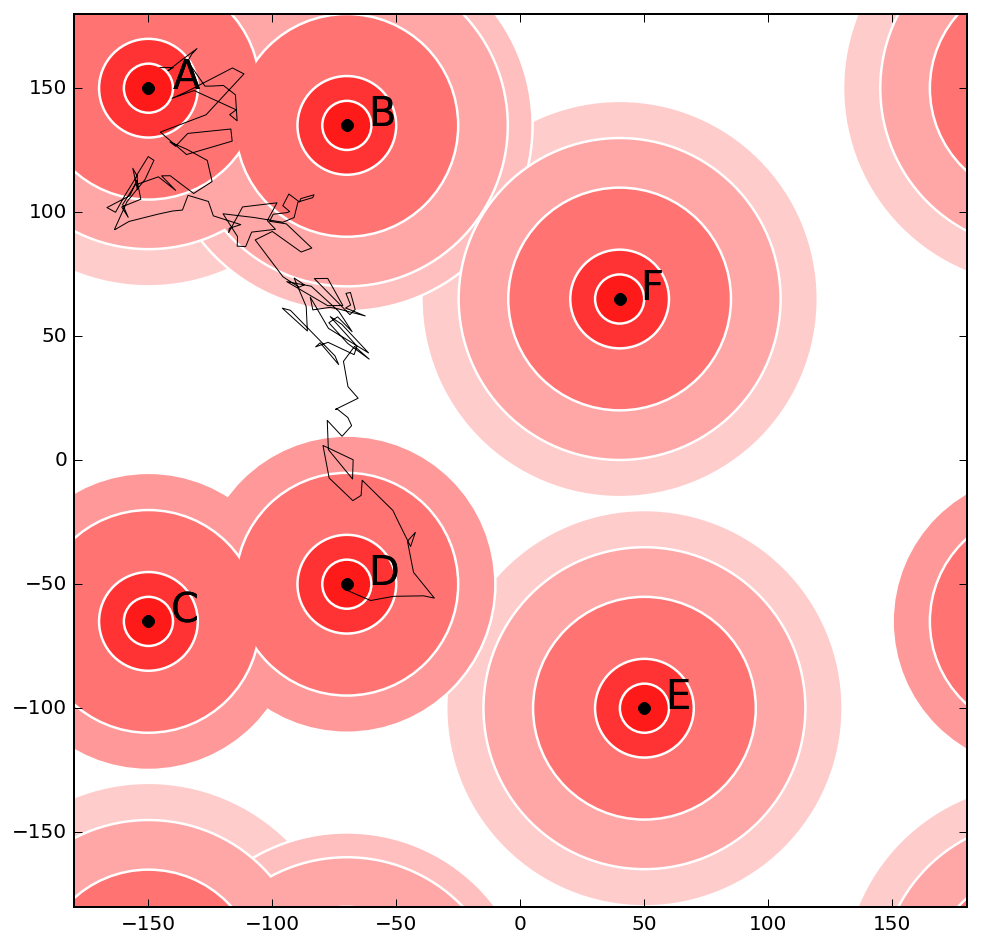

In [52]:
plot_main()
plot_traj(traj2)

In [53]:
paths.SampleGeneratingMover.engine = engine
tis_trans = paths.TISTransition(
    stateA=stBeta,
    stateB=stAlpha,
    interfaces=interface_list['beta'],
    name="alpha->beta equil",
    orderparameter=None # default order parameter for analysis; not used
)

In [39]:
initial_globalstate = paths.SampleSet.map_trajectory_to_ensembles(traj2, tis_trans.ensembles)

In [40]:
for sample in initial_globalstate:
    print sample, sample.ensemble(sample), stAlpha(sample[-1]), stBeta(sample[0])

Replica: 0
Trajectory: Trajectory[165]
Ensemble: <openpathsampling.ensemble.TISEnsemble object at 0x1150ec890>
 True True True
Replica: 1
Trajectory: Trajectory[165]
Ensemble: <openpathsampling.ensemble.TISEnsemble object at 0x10f2d1410>
 True True True
Replica: 2
Trajectory: Trajectory[165]
Ensemble: <openpathsampling.ensemble.TISEnsemble object at 0x10f89d050>
 True True True
Replica: 3
Trajectory: Trajectory[165]
Ensemble: <openpathsampling.ensemble.TISEnsemble object at 0x113cb9f10>
 True True True
Replica: 4
Trajectory: Trajectory[165]
Ensemble: <openpathsampling.ensemble.TISEnsemble object at 0x113f95450>
 True True True
Replica: 5
Trajectory: Trajectory[165]
Ensemble: <openpathsampling.ensemble.TISEnsemble object at 0x113cc2a10>
 True True True


In [41]:
initial_globalstate.sanity_check()

In [42]:
equilibration = paths.PathSampling(
    storage=None, 
    engine=engine, 
    move_scheme=tis_trans.default_schemes(engine),
    globalstate=initial_globalstate
)

In [43]:
equilibration.globalstate.sanity_check()

In [79]:
[samp for samp in equilibration.globalstate if samp.ensemble.name == "I'face 0"][0]

[<Sample @ 0x10f331090>]

In [ ]:
equilibration.globalstate[0].trajectory[0]

In [77]:
stBeta(equilibration.globalstate[0].trajectory[0])

True

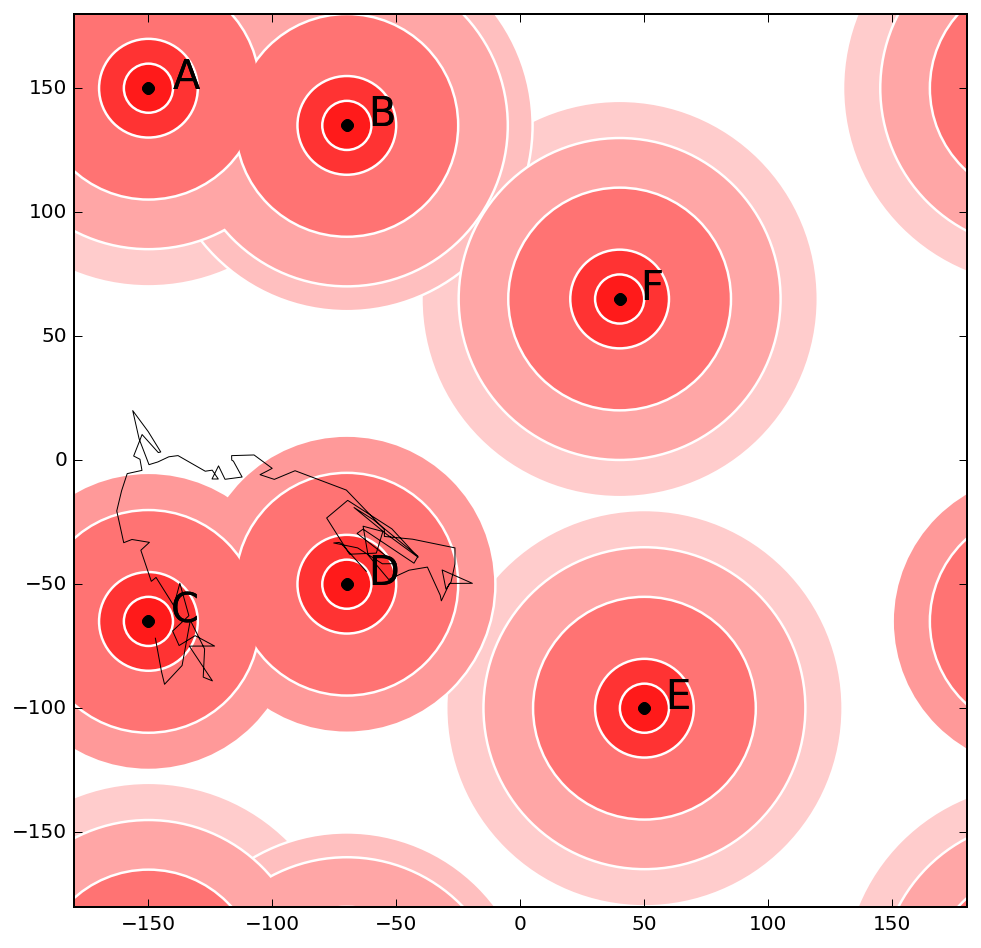

In [81]:
plot_main()
plot_traj([samp for samp in equilibration.globalstate if samp.ensemble.name == "I'face 2"][0].trajectory)

I'face 2
I'face 4
I'face 0
I'face 3
I'face 5
I'face 1


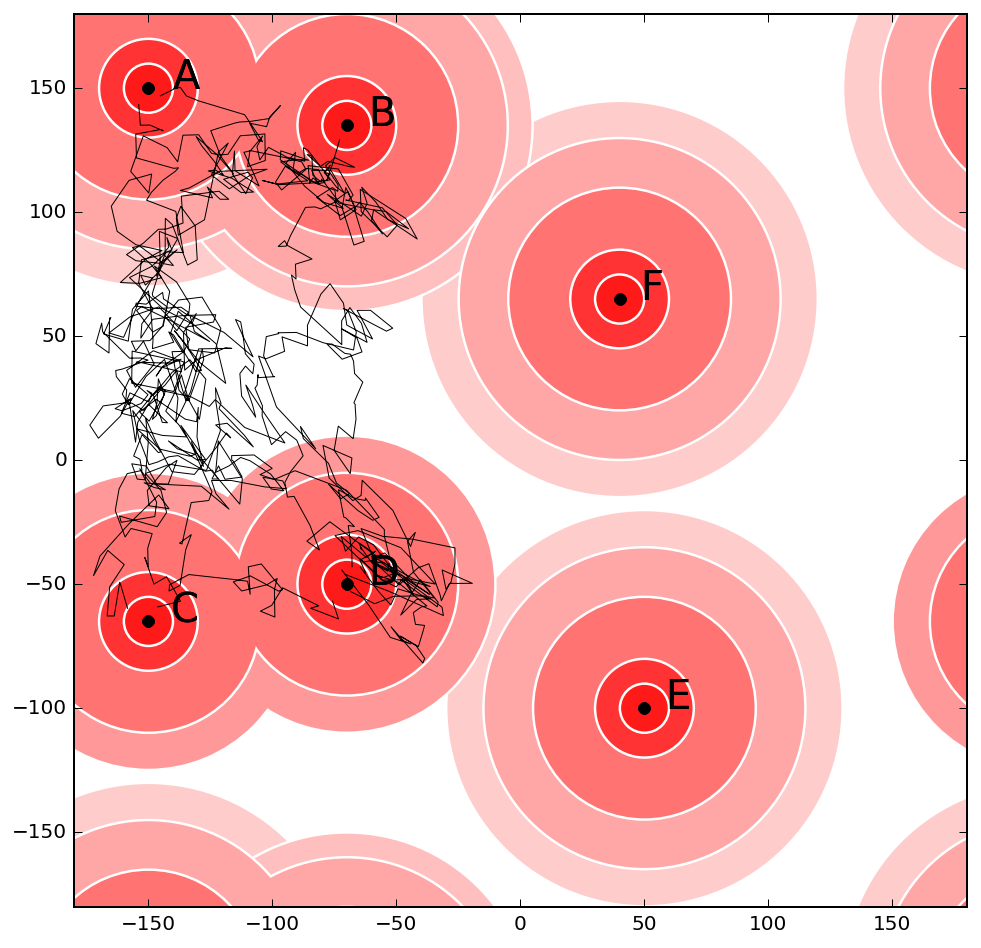

In [85]:
plot_main()
for sample in equilibration.globalstate:
    print sample.ensemble.name
    if sample.replica < 6:
        plot_traj(sample.trajectory)

In [82]:
equilibration.run(50)

DONE! Completed 120 Monte Carlo cycles.



In [84]:
while not stBeta(equilibration.globalstate[0].trajectory[-1]): # keep equilibrating until innermost can extend to minus CLEAN THIS LATER
    equilibration.run(1)

In [87]:
retis_trans = paths.RETISTransition(
    stateA=stBeta,
    stateB=stAlpha,
    interfaces=interface_list['beta'],
    name="A->B",
    orderparameter=op_state['D'] # we'll use this in the analysis notebook
)

start_gs = paths.SampleSet.translate_ensembles(equilibration.globalstate, retis_trans.ensembles)

In [91]:
minus_samp = retis_trans.minus_ensemble.populate_minus_ensemble(
    partial_traj=equilibration.globalstate[0].trajectory,
    minus_replica_id=-1,
    engine=engine
)
start_gs = start_gs.apply_samples([minus_samp])

In [92]:
start_gs.sanity_check()

In [ ]:
import logging.config
logging.config.fileConfig("logging.conf", disable_existing_loggers=False)

In [93]:
store_retis = paths.storage.Storage("weina_production.nc", "w", template=template)
store_retis.save(retis_trans)

Not good. Your function relies on globally set variables and these cannot be saved!
requires the following globals to be set: ['degrees']
Check, if you can replace these by constants or variables that are defined within the function itself
Not good. Your function relies on globally set variables and these cannot be saved!
requires the following globals to be set: ['degrees']
Check, if you can replace these by constants or variables that are defined within the function itself
Not good. Your function relies on globally set variables and these cannot be saved!
requires the following globals to be set: ['degrees']
Check, if you can replace these by constants or variables that are defined within the function itself
Not good. Your function relies on globally set variables and these cannot be saved!
requires the following globals to be set: ['degrees']
Check, if you can replace these by constants or variables that are defined within the function itself


True

In [94]:
production = paths.PathSampling(
    storage=store_retis,
    engine=engine,
    move_scheme=retis_trans.default_schemes(engine),
    globalstate=start_gs
)
production.save_frequency = 10

In [95]:
production.run(200)

DONE! Completed 200 Monte Carlo cycles.



In [110]:
for cv in store_retis.cvs:
    _ = cv(store_retis.snapshots[:])

In [111]:
store_retis.cvs.sync()

In [112]:
store_retis.sync()

[MinusInterfaceEnsemble]
I'face 0
I'face 1
I'face 3
I'face 2
I'face 5
I'face 4


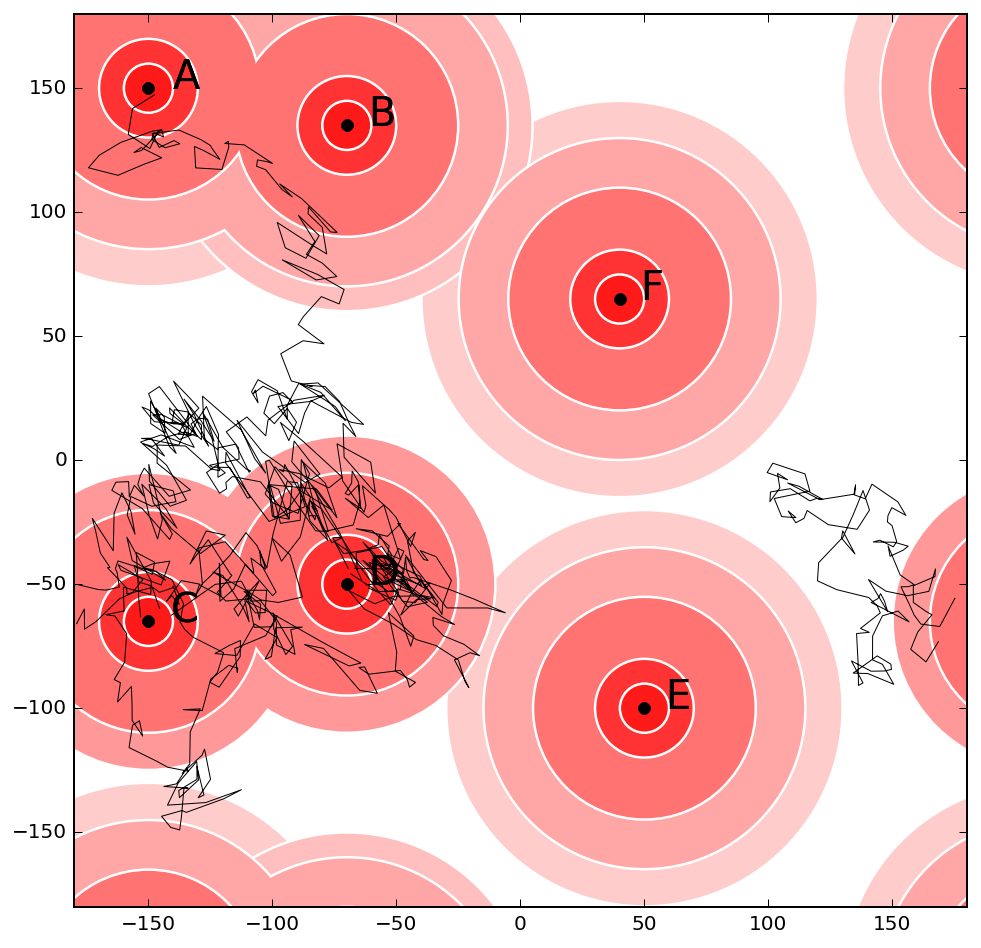

In [137]:
plot_main()
for sample in production.globalstate:
    print sample.ensemble.name
    if sample.replica < 6:
        plot_traj(sample.trajectory)

In [113]:
ana = paths.storage.Storage("weina_production.nc", mode="r")

In [142]:
tr = ana.transitions[0]

In [207]:
step = ana.steps[1]

In [196]:
step = ana.steps[2]
print rep_list

[(u"I'face 0", 0, 1), (u"I'face 1", 1, 3), (u"I'face 2", 2, 6), (u"I'face 3", 3, 5), (u"I'face 4", 4, 0), (u"I'face 5", 5, 2)]


In [175]:
step.active[5].ensemble.name

u"I'face 2"

In [216]:
%%time
step.active[tr.ensembles[0]]

CPU times: user 24 µs, sys: 11 µs, total: 35 µs
Wall time: 34.1 µs


<Sample @ 0x17c8ca150>

In [205]:
u = np.zeros((6, 6, len(ana.steps) - 1))
for k, sn_idx in enumerate(rep_list):
    for l, ens in enumerate(tr.ensembles[0:5]):
        print k * 5 + l,
        for step in range(10 + 0*len(ana.steps) - 1):
            sset = ana.steps[step + 1].active
            replica = [ sn_idx for sn_idx in range(6) if sset[sn_idx].ensemble is ens][0]
            u[k,l,step] = 0.0 if ens(sset[replica]) else -20.0

 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29


In [ ]:
u

In [172]:
print iface.name

I'face 3


In [114]:
ana.samples.cache_all()
ana.samplesets.cache_all()
ana.pathmovechanges.cache_all()
ana.steps.cache_all()
map(lambda x : x.cache_all(ana), ana.cvs)

[None, None, None, None, None, None]

In [139]:
import pymbar

In [179]:
?pymbar.mbar.MBAR

In [121]:
print [len(traj) for traj in ana.trajectories]

[74, 298, 54, 215, 84, 113, 90, 298, 188, 113, 54, 74, 64, 170, 50, 113, 298, 307, 321, 50, 139, 117, 298, 298, 113, 203, 298, 101, 298, 292, 63, 84, 104, 142, 74, 71, 292, 157, 92, 148, 142, 268, 148, 146, 265, 150, 163, 142, 158, 175, 29, 81, 54, 53, 53, 189, 5, 191, 108, 158, 71, 53, 476, 142, 142, 148, 55, 90, 476, 179, 53, 179, 94, 164, 212, 246, 56, 238, 56, 33, 153, 142, 122, 122, 58, 122, 217, 58, 51, 461, 196, 54, 79, 51, 149, 149, 149, 75, 332, 149, 51, 173, 143, 153, 246, 17, 17, 143, 172, 280, 51, 280, 119, 129, 17, 17, 119, 17, 92, 89, 142, 89, 142, 153, 50, 17, 293, 280, 199, 116, 101, 28, 28, 89, 154, 89, 277, 28, 293, 28, 28, 10, 293, 280, 90, 293, 28, 28, 1217, 10, 440, 10, 154, 269, 190, 10, 310, 292, 292, 10, 269, 10, 292, 177, 269, 28, 17, 90, 50]


In [126]:
print [cc.name for cc in ana.cvs[:]]

[u'opC', u'phi', u'psi', u'opD', u'opA', u'opB']


In [132]:
ccc = ana.cvs[3]
print sorted([max(ccc(traj)) for traj in ana.trajectories])

[19.455289840698242, 32.820701599121094, 33.2904052734375, 33.2904052734375, 33.2904052734375, 33.2904052734375, 33.943302154541016, 33.943302154541016, 38.7887077331543, 38.7887077331543, 38.7887077331543, 38.7887077331543, 38.7887077331543, 38.7887077331543, 38.7887077331543, 38.7887077331543, 38.7887077331543, 40.93824768066406, 44.158382415771484, 44.158382415771484, 44.158382415771484, 44.158382415771484, 47.604225158691406, 53.91679763793945, 55.279991149902344, 59.020809173583984, 64.09132385253906, 64.50643920898438, 64.50643920898438, 64.96923065185547, 64.96923065185547, 64.96923065185547, 64.96923065185547, 64.96923065185547, 65.211669921875, 65.211669921875, 65.211669921875, 65.211669921875, 65.211669921875, 65.211669921875, 66.42794799804688, 66.42794799804688, 66.42794799804688, 66.42794799804688, 66.42794799804688, 66.42794799804688, 66.42794799804688, 90.25562286376953, 101.3293685913086, 101.3293685913086, 102.03675079345703, 102.03675079345703, 102.03675079345703, 102

In [135]:
retis = ana.transitions.load(0)
retis.hist_args['pathlength'] = { 'bin_width' : 10, 'bin_range' : (20, 300) }
retis.hist_args['max_lambda'] = { 'bin_width' : 10, 'bin_range' : (20, 250) }

In [136]:
retis.rate(ana)

ValueError: math domain error

In [88]:
toward_core_ensemble = paths.SequentialEnsemble(
    [
            paths.AllOutXEnsemble( stAll ),
            paths.AllInXEnsemble( stAll ) & paths.LengthEnsemble(1)
    ])

def get_outof_core_ensemble(state):
    return paths.SequentialEnsemble(
        [ paths.AllInXEnsemble( interface ) | paths.LengthEnsemble(0) for interface in interface_list[state] ]
    + [ 
        paths.AllOutXEnsemble( interface_list[state][-1] ),
        paths.AllInXEnsemble( stAll )
    ])

out_ensembles = {
    name : get_outof_core_ensemble(name)
    for name in ['A', 'B', 'C', 'D', 'E', 'F']
}

In [24]:
mstis = paths.MSTISNetwork([
    (interface_list[state][0], interface_list[state][0:], state, op_state[state]) for
    state in ['A', 'B', 'C', 'D', 'E', 'F']
])

In [49]:
import sys
def full_bootstrap(transition, snapshot, engine, extra_interfaces=[], storage=None):
    interface0 = transition.interfaces[0]
    ensemble0 = transition.ensembles[0]
    state = transition.stateA
    first_traj_ensemble = paths.SequentialEnsemble([
        paths.OptionalEnsemble(paths.AllOutXEnsemble(state)),
        paths.AllInXEnsemble(state),
        paths.OptionalEnsemble(paths.AllOutXEnsemble(state) & paths.AllInXEnsemble(interface0)),
        paths.OptionalEnsemble(paths.AllInXEnsemble(interface0)),
        paths.AllOutXEnsemble(interface0),
        paths.OptionalEnsemble(paths.AllOutXEnsemble(state)),
        paths.SingleFrameEnsemble(paths.AllInXEnsemble(state))
    ])
    #print first_traj_ensemble #DEBUG
    engine.current_snapshot = snapshot
    engine.snapshot = snapshot
    print "Building first trajectory"
    sys.stdout.flush()
    first_traj = engine.generate(engine.current_snapshot, [first_traj_ensemble.can_append])
    print "Selecting segment"
    sys.stdout.flush()
    subtraj = ensemble0.split(first_traj)[0]
    extra_ensembles = [
        paths.TISEnsemble(transition.stateA, transition.stateB, iface, transition.orderparameter)
        for iface in extra_interfaces
    ] 
#     extra_ensembles.append(
#         paths.SequentialEnsemble([
#             paths.AllInXEnsemble(transition.interfaces[-1]),
#             paths.AllInXEnsemble(~ (transition.interfaces[-2] | transition.stateB)),
#             paths.AllInXEnsemble(transition.stateB)
#         ])
#     )
    extra_shooters = [paths.OneWayShootingMover(paths.UniformSelector(), ens) for ens in extra_ensembles]
    print "Sampling " + str(len(transition.ensembles+extra_ensembles)) + " ensembles."
    bootstrap = paths.Bootstrapping(
        storage=storage,
        ensembles=transition.ensembles+extra_ensembles,
        movers=transition.movers['shooting']+extra_shooters,
        trajectory=subtraj
    )
    print "Beginning bootstrapping"
    while len(bootstrap.globalstate) < len(transition.ensembles+extra_ensembles):
        print len(bootstrap.globalstate), "samples so far"
        sys.stdout.flush()
        bootstrap.run(20)
    print len(bootstrap.globalstate), "samples so far (DONE!)"
    return bootstrap.globalstate



In [26]:
traj = engine.generate(storage.template, [toward_core_ensemble.can_append])

In [27]:
get_interface(traj[-1])


('D', 0)

In [28]:
curr_snapshot = traj[-1]

In [72]:
state = get_state(traj[-1])
print state
transition = mstis.from_state[interface_list[state][0]]
print transition

sset = full_bootstrap(
    transition, 
    curr_snapshot, 
    engine, 
    extra_interfaces=[transition.interfaces[-1]])

DONE! Completed Bootstrapping cycle step 307 in ensemble 4/4 .

4 samples so far (DONE!)


In [ ]:
traj2 = sset[3].trajectory

In [ ]:
''.join([str(get_interface(sn)[0]) for sn in traj2])

In [87]:
traj2 = engine.generate(curr_snapshot, [out_ensembles[get_state(curr_snapshot)].can_append])
curr_snapshot = traj2[-1]
get_interface(curr_snapshot)
''.join({get_state(sn) for sn in traj2})

('D', 3)

In [81]:

interface_list['D'][-1](traj2[-1])

True

In [69]:
get_interface(traj2[-1])

('D', 3)

Some convenience variables

Create 6 TISTransition objects. With a little trick we always use stAll as the target state

In [27]:
print mstis

Multiple State TIS Network:
RETISTransition: Out C
C -> C or all states except C
Interface: C
Interface: 0.0<opC<20.0
Interface: 0.0<opC<45.0
RETISTransition: Out A
A -> A or all states except A
Interface: A
Interface: 0.0<opA<20.0
Interface: 0.0<opA<45.0
Interface: 0.0<opA<65.0
RETISTransition: Out F
F -> F or all states except F
Interface: F
Interface: 0.0<opF<20.0
Interface: 0.0<opF<45.0
Interface: 0.0<opF<65.0
RETISTransition: Out B
B -> B or all states except B
Interface: B
Interface: 0.0<opB<20.0
Interface: 0.0<opB<45.0
Interface: 0.0<opB<65.0
RETISTransition: Out E
E -> E or all states except E
Interface: E
Interface: 0.0<opE<20.0
Interface: 0.0<opE<45.0
Interface: 0.0<opE<65.0
RETISTransition: Out D
D -> D or all states except D
Interface: D
Interface: 0.0<opD<20.0
Interface: 0.0<opD<45.0



In [26]:
for state in mstis.from_state.keys():
    print state.name
    init = storage.template
    transition = mstis.from_state[state]
    
    full_bootstrap(
        mstis.from_state[state], 
        storage.template, 
        engine, 
        extra_interfaces=[transition.interfaces[-1]])

A
Building first trajectory


KeyboardInterrupt: 

Now we need a way to get first connecting trajectories

In [40]:
interface0 = line_volume_set[0]
first_traj_ensemble = SequentialEnsemble([
    OptionalEnsemble(AllOutXEnsemble(stateA)),
    AllInXEnsemble(stateA),
    OptionalEnsemble(AllOutXEnsemble(stateA) & AllInXEnsemble(interface0)),
    OptionalEnsemble(AllInXEnsemble(interface0)),
    AllOutXEnsemble(interface0),
    OptionalEnsemble(AllOutXEnsemble(stateA)),
    SingleFrameEnsemble(AllInXEnsemble(stateA))
])

### Ensembles

Now do this automatically for all ensembles

In [29]:
?ps.TISTransition

In [11]:
interface0 = volume_set[0]
interface_set = ef.TISEnsembleSet(stateA, stateA | stateB, volume_set)
for no, interface in enumerate(interface_set):
    # Give each interface a name
    interface.uid = 'Interface '+str(no)
    # And save all of these
    storage.ensemble.save(interface)

And create a special ensemble, that will create a first trajectory in the innermost TIS ensemble independent from where we start

The idea is to describe a trajectory type by a sequence of positions. First can be outside of stateA or not, then be inside stateA, etc...

In [12]:
    first_traj_ensemble = SequentialEnsemble([
        AllOutXEnsemble(stateA) | LengthEnsemble(0),
        AllInXEnsemble(stateA),
        (AllOutXEnsemble(stateA) & AllInXEnsemble(interface0)) | LengthEnsemble(0),
        AllInXEnsemble(interface0) | LengthEnsemble(0),
        AllOutXEnsemble(interface0),
        AllOutXEnsemble(stateA) | LengthEnsemble(0),
        AllInXEnsemble(stateA) & LengthEnsemble(1)
    ])

### start path generation

so lets try and see if we can generate a first path

load the initial snapshot (although we still have it) and generate using the Alanine simulator. The second option specifies a function : trajectory -> bool that keeps the simulation running as long as it is true. Our goal was to generate a path that belongs to a specific ensemble, so we use `forward` to determine if it makes sense to keep running or if the result cannot belong to the ensemble anymore.

In [13]:
snapshot = storage.load(Snapshot, 0)
total_path = engine.generate(
    snapshot= snapshot, 
    running = [first_traj_ensemble.can_append]
)

Show the length

In [14]:
print "Total trajectory length: ", len(total_path)

Total trajectory length:  80


And save the trajetory completely

In [15]:
storage.save(total_path);

Split the trajectory into parts that belong to the TIS ensemble (not the one we generated)

In [16]:
interface0_ensemble = interface_set[0]
segments = interface0_ensemble.split(total_path)

print "Traj in first_traj_ensemble? (should be)", 
print first_traj_ensemble(total_path)

print "Traj in TIS ensemble? (probably not)", 
print interface0_ensemble(total_path)


print "Number of segments in TIS ensemble: ", len(segments)
if len(segments):
    print "Length of each segment:"
    for i in range(len(segments)):
        print "  seg[{0}]: {1}".format(i, len(segments[i]))

Traj in first_traj_ensemble? (should be) True
Traj in TIS ensemble? (probably not) False
Number of segments in TIS ensemble:  1
Length of each segment:
  seg[0]: 13


Show some results and check if this worked

In [17]:
data = []
for frame in total_path:
    data.append((phi(frame)[0]*degrees, psi(frame)[0]*degrees, stateA(frame), interface0(frame), stateB(frame), first_traj_ensemble.can_append(total_path[slice(0,total_path.index(frame)+1)])))
    
dataframe = pd.DataFrame(data, columns=['phi', 'psi', 'stateA', 'interface0', 'stateB', 'appendable'])
dataframe[[0,1,2,3,4,5]].ix[[0,1,2,len(dataframe)-3,len(dataframe)-2,len(dataframe)-1]]

,phi,psi,stateA,interface0,stateB,appendable
0,-80.208523,-10.277041,[False],[False],[False],True
1,-82.304874,-11.558130,[False],[False],[False],True
2,-80.008760,-12.416635,[False],[False],[False],True
77,-103.933178,-22.632633,[False],[False],[False],True
78,-117.134633,-23.749964,[False],[False],[False],True
79,-108.535247,-31.290209,[True],[True],[False],False


In [18]:
print "Do our segments satisfy the ensemble?",
for seg in segments:
    print interface0_ensemble(seg),

Do our segments satisfy the ensemble? True


In [19]:
data = []
for frame in segments[0]:
    data.append((phi(frame)[0]*degrees, psi(frame)[0]*degrees, stateA(frame), interface0(frame), stateB(frame), first_traj_ensemble.can_append(total_path[slice(0,total_path.index(frame)+1)])))
    
dataframe = pd.DataFrame(data, columns=['phi', 'psi', 'stateA', 'interface0', 'stateB', 'appendable'])
dataframe[[0,1,2,3,4,5]]

,phi,psi,stateA,interface0,stateB,appendable
0,-99.240178,-38.512324,[True],[True],[False],True
1,-103.622889,-27.220832,[False],[True],[False],True
2,-99.338150,-26.295467,[False],[True],[False],True
3,-111.781775,-24.924911,[False],[False],[False],True
4,-106.410756,-28.791652,[False],[True],[False],True
5,-111.632460,-25.316698,[False],[True],[False],True
6,-113.998658,-26.205725,[False],[True],[False],True
7,-108.038145,-21.390460,[False],[False],[False],True
8,-108.417672,-25.400952,[False],[True],[False],True
9,-110.197996,-18.481640,[False],[False],[False],True


### Bootstrapping

Run a bootstrapping (not TIS) simulation that shoots from an ensemble until the next interface is reached then switch to the next ensemble to drive the system out of stateA

In [20]:
mover_set = mf.OneWayShootingSet(UniformSelector(), interface_set)

In [21]:
bootstrap = Bootstrapping(storage=storage,
                          engine=engine,
                          ensembles=interface_set,
                          movers=mover_set,
                          trajectory=segments[0])

Run Bootstrapping with at most 50 attempts per ensemble

In [22]:
bootstrap.run(10)

Save all computed phi/psi values which depends on whether they have been needed before

In [23]:
storage.collectivevariable.sync(psi);
storage.collectivevariable.sync(phi);

Create an collectivevariable from a volume which is just 1 or 0 and can thus be stored for later analysis

In [24]:
op_inA = CV_Volume('StateA', stateA)
op_inA.uid = 'StateA'
op_inB = CV_Volume('StateB', stateB)
op_inB.uid = 'StateB'
op_notinAorB = CV_Volume('StateX', ~ (stateA | stateB))
op_notinAorB.uid = 'StateX'

Compute the collectivevariable for all snapshots

In [25]:
op_inA(storage.snapshot.all())
op_inB(storage.snapshot.all())
op_notinAorB(storage.snapshot.all());

Save the new collectivevariables

In [26]:
storage.save([op_inA, op_inB, op_notinAorB]);

## Visualization

Create a PathTree generator

In [27]:
tree = PathTreeBuilder(storage)
op_inA.name
storage.save(op_inA)
storage.cv.load(0)
op_inA.idx

{Storage @ 'trajectory.nc': 2}

Change the settings to show rejected pathways, mark OrderParaemters `stateA` and `stateX`, and show the 'psi' value as text inside of the boxes

In [28]:
tree.rejected = True
tree.states = [('StateA','orange'),('StateX','black')]
# Some ideas for collectivevariables to visualize
tree.op = lambda snap : 'B' if snap.reversed else 'F'
tree.op = storage.configuration.op_idx
tree.op = lambda snap : int(psi(snap)[0]/3.1415926 * 180)

tree.from_samples(tree.construct_heritage(storage, storage.sample.last()))

Render the tree

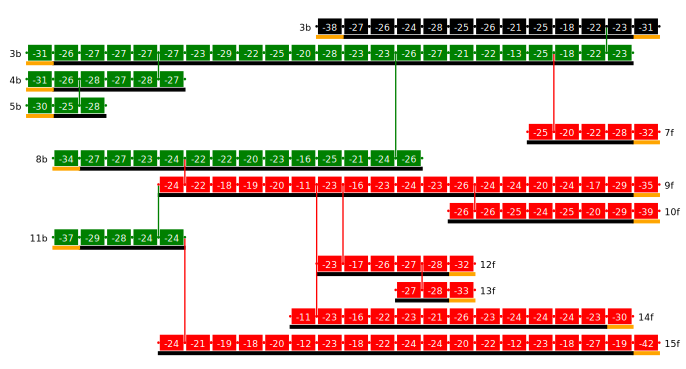

In [29]:
view = tree.renderer
view.zoom = 1.1
view.scale_y = 24
view.scale_x = 24
view.font_size = 0.35
SVG(view.to_svg())

An alternate view which is similar to the standard way of plotting

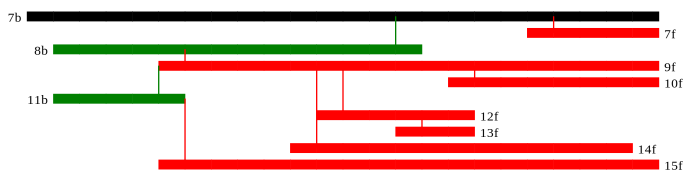

In [30]:
tree.rejected = False
tree.states = []
tree.op = None
samples = storage.sample.by_ensemble(storage.ensemble.load(4))
tree.from_samples(samples)
view = tree.renderer
view.zoom = 1.1
view.horizontal_gap = -0.01
view.scale_y = 15
view.scale_x = 24
view.font_size = 0.8
view.font_family = 'Times'
SVG(view.to_svg())

### Phi/Psi Plots

In [31]:
# Imports for plotting
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib.legend_handler import HandlerLine2D

Make sure that all phi/psi values have been computed!

In [32]:
phi(storage.snapshot.all());
psi(storage.snapshot.all());

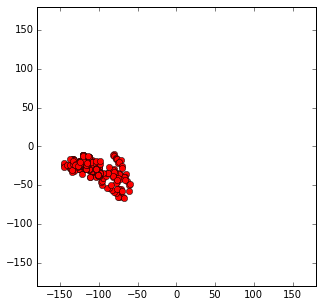

In [33]:
plt.figure(figsize=(5, 5))

for traj in storage.trajectory.iterator():
    phi_angles = degrees * np.array(phi(traj)).flatten()
    psi_angles = degrees * np.array(psi(traj)).flatten()
    plt.plot(phi_angles, psi_angles, 'ro', linewidth=1);
    
plt.xlim(-180, 180);
plt.ylim(-180, 180);

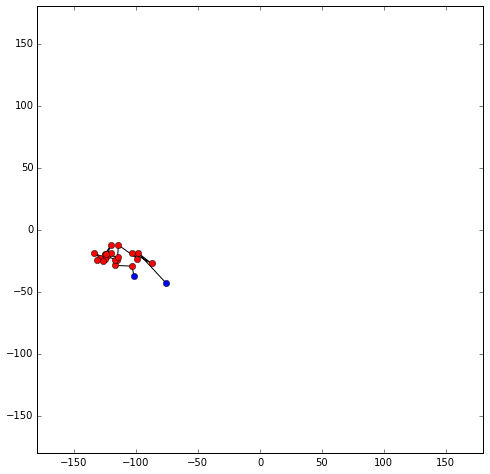

In [34]:
plt.figure(figsize=(8, 8))

traj = storage.trajectory.last()
phi_angles = degrees * np.array(phi(traj)).flatten()
psi_angles = degrees * np.array(psi(traj)).flatten()
plt.plot(phi_angles, psi_angles, 'k-', linewidth=1);

for snapshot in traj:
    phi_angles = degrees * np.array(phi(snapshot)).flatten()
    psi_angles = degrees * np.array(psi(snapshot)).flatten()
    if op_notinAorB(snapshot):
        plt.plot(phi_angles, psi_angles, 'ro', linewidth=1);
    else:
        plt.plot(phi_angles, psi_angles, 'bo', linewidth=1);
        
plt.xlim(-180, 180);
plt.ylim(-180, 180);

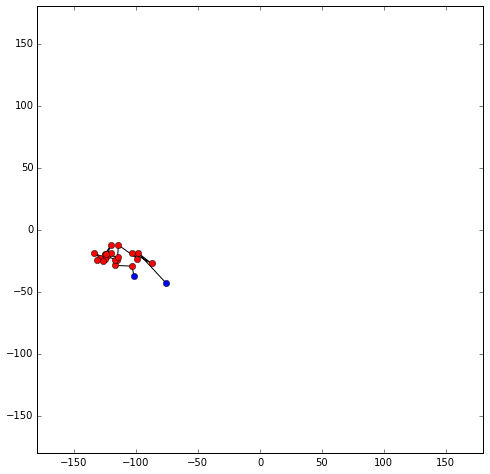

In [35]:
plt.figure(figsize=(8, 8))

traj = storage.sample.last().trajectory
phi_angles = degrees * np.array(phi(traj)).flatten()
psi_angles = degrees * np.array(psi(traj)).flatten()
plt.plot(phi_angles, psi_angles, 'k-', linewidth=1);


#for snapshot in simulator.storage.snapshot.iterator():
for snapshot in traj:
    phi_angles = degrees * np.array(phi(snapshot)).flatten()
    psi_angles = degrees * np.array(psi(snapshot)).flatten()
    if op_notinAorB(snapshot):
        plt.plot(phi_angles, psi_angles, 'ro', linewidth=1);
    else:
        plt.plot(phi_angles, psi_angles, 'bo', linewidth=1);
        
plt.xlim(-180, 180);
plt.ylim(-180, 180);

In [36]:
storage.cv.sync()
storage.sync()